In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
import scipy
import scipy as sp
from scipy.optimize import fsolve
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv
from scipy.optimize import fsolve

In [6]:
alpha = 0.8; Bo=0.1; Ca=0.1; Re=1; Ma=0.; epsilon=0.1

In [7]:
def w_0(x):
    r = ((1-alpha)*x+1+alpha)/2
    return 1/4*(2*np.log(r/alpha) - (r**2 - alpha**2))
def w_0_prime(x): 
    r = ((1-alpha)*x+1+alpha)/2
    return 1/2*(1/r - r)
def w_0_prime_prime(x):
    r = ((1-alpha)*x+1+alpha)/2
    return -1/2*(1/r**2 + 1)
w_0 = np.vectorize(w_0)
w_0_prime = np.vectorize(w_0_prime)
w_0_prime_prime = np.vectorize(w_0_prime_prime)

In [8]:
N =  70
x = np.flip(cheb.chebgauss(N+1)[0])

x_interior = x[2:(N-1)]
print(len(x_interior))
print(len(x))
matrix = np.zeros((N+1, N+1))
#build the polys at the points
cheb_poly = np.zeros((N+1, N+1))
cheb_der = np.zeros_like(cheb_poly)
cheb_der_der = np.zeros_like(cheb_poly)
cheb_der3 = np.zeros_like(cheb_poly)
cheb_der4 = np.zeros_like(cheb_poly)
# row is the order, column is the evaluation point
cheb_poly[0,:] = 1
cheb_poly[1,:] = x
cheb_der[1,:] = 1
for k in range(2,N+1):
    cheb_poly[k,:] = 2*x*cheb_poly[k-1,:] - cheb_poly[k-2,:]
    cheb_der[k,:] = 2*cheb_poly[k-1] + 2*x*cheb_der[k-1, :] - cheb_der[k-2, :]
    cheb_der_der[k,:] = 4*cheb_der[k-1] + 2*x*cheb_der_der[k-1, :] - cheb_der_der[k-2, :]
    cheb_der3[k,:] = 6*cheb_der_der[k-1] + 2*x*cheb_der3[k-1, :] - cheb_der3[k-2, :]
    cheb_der4[k,:] = 8*cheb_der3[k-1] + 2*x*cheb_der4[k-1, :] - cheb_der4[k-2, :]

67
71


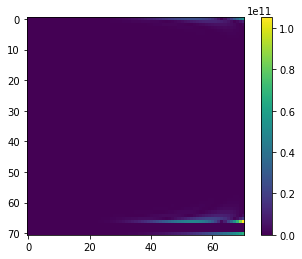

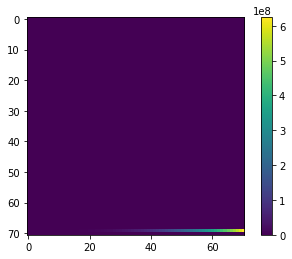

Eigen function


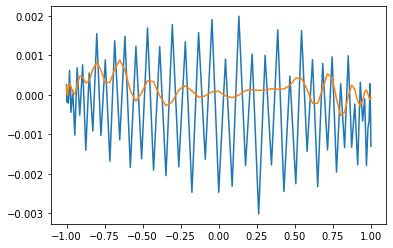

3.3333333333333335
6.666666666666667
10.0
13.333333333333334
16.666666666666664
20.0
23.333333333333332
26.666666666666668
30.0
33.33333333333333


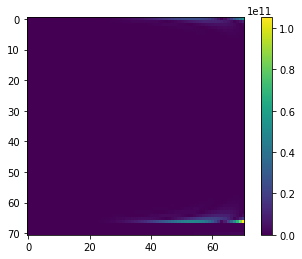

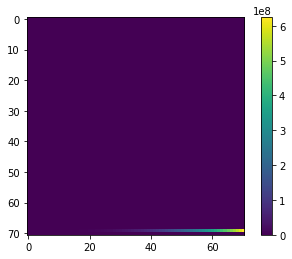

Eigen function


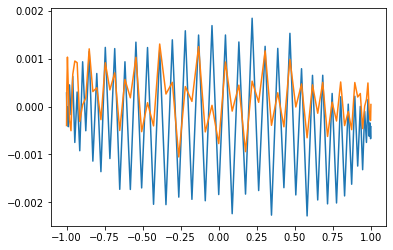

36.666666666666664
40.0
43.333333333333336
46.666666666666664
50.0
53.333333333333336
56.666666666666664
60.0
63.33333333333333
66.66666666666666


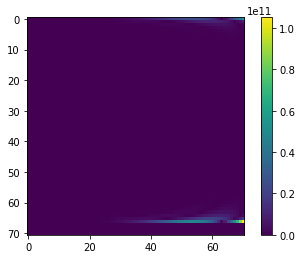

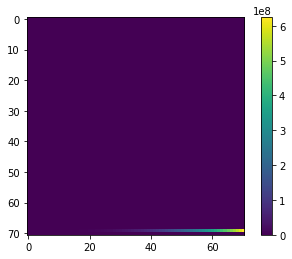

Eigen function


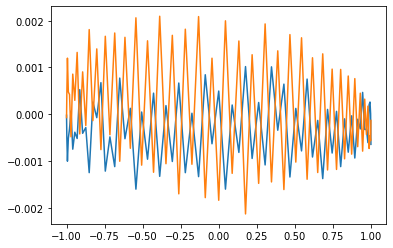

70.0
73.33333333333333
76.66666666666667
80.0
83.33333333333334
86.66666666666667
90.0
93.33333333333333
96.66666666666667
100.0


In [9]:
# I want all the equations to be more or less the same size
kappa_vect = np.linspace(0.01, 1, 30)
Lambda_vect = np.zeros_like(kappa_vect)
Lambda_vect_artificial = np.zeros_like(kappa_vect)
r_interior = ((1-alpha)*x_interior + (1 + alpha))/2 #(half)
r = ((1-alpha)*x + (1 + alpha))/2 
factor = 2/(1-alpha)
for index, k in enumerate(kappa_vect):
    matrix_interior_LHS = np.zeros((N-3,N+1), dtype=complex)
    matrix_interior_RHS = np.zeros((N-3,N+1), dtype=complex)
    # stokes operator
    #print(np.shape(matrix_interior_LHS))
    matrix_interior_LHS += np.transpose(k**4*r_interior**3*cheb_poly[:,2:(N-1)])
    matrix_interior_LHS += np.transpose(r_interior**3*cheb_der4[:,2:(N-1)]*factor**4)
    matrix_interior_LHS += np.transpose(-2*r_interior**2*cheb_der3[:,2:(N-1)]*factor**3)
    matrix_interior_LHS += np.transpose((3*r_interior - 2*k**2*r_interior**3)*cheb_der_der[:, 2:(N-1)]*factor**2)
    matrix_interior_LHS += np.transpose((2*k**2*r_interior**2 - 3)*cheb_der[:,2:(N-1)]*factor)
    
    #inertia terms
    #RHS
    matrix_interior_RHS += Re*np.transpose(-r_interior**3*cheb_der_der[:,2:(N-1)]*factor**2)
    matrix_interior_RHS += Re*np.transpose(r_interior**2*cheb_der[:,2:(N-1)]*factor)
    matrix_interior_RHS += Re*np.transpose(r_interior**3*k**2*cheb_poly[:,2:(N-1)])
    #LHS
    matrix_interior_LHS += Re*np.transpose(-1j*r_interior**3*k*w_0(r_interior)*cheb_der_der[:,2:(N-1)]*factor**2)
    matrix_interior_LHS += Re*np.transpose(1j*r_interior**3*w_0_prime_prime(r_interior)*k*cheb_poly[:,2:(N-1)])
    matrix_interior_LHS += Re*np.transpose(1j*w_0(r_interior)*k*r_interior**2*cheb_der[:,2:(N-1)]*factor)
    matrix_interior_LHS += Re*np.transpose(-1j*r_interior**2*k*w_0_prime(r_interior)*cheb_poly[:,2:(N-1)])
    matrix_interior_LHS += Re*np.transpose(1j*r_interior**3*k**3*w_0(r_interior)*cheb_poly[:,2:(N-1)])
    
    
    matrix_interior_LHS = matrix_interior_LHS/factor**4
    matrix_interior_RHS = matrix_interior_RHS/factor**4
    
    no_slip_u = np.transpose(cheb_poly[:,0]).reshape(1,-1)
    no_slip_w = np.transpose(cheb_der[:,0]*factor).reshape(1,-1)
    S = factor*cheb_der[:,-1] - factor**2*cheb_der_der[:,-1] - k**2*cheb_poly[:,-1] #tangential stress
    kinematic_LHS = np.transpose(1j*k*cheb_poly[:,-1] - 1j*k*w_0(1)*S).reshape(1,-1)
    kinematic_RHS = np.transpose(S).reshape(1,-1)
    
    p_terms = 1/k*(1j*cheb_der3[:,-1]*factor**3 - 1j*cheb_der_der[:, -1]*factor**2 + (w_0(1)*Re*k+1j-1j*k**2)*cheb_der[:,-1]*factor)
    normal_stress_LHS = np.transpose(Bo*p_terms-2*Ca*1j*k*(cheb_der[:,-1]*factor-cheb_poly[:,-1])+(1-2*Ma)*S-k**2*S).reshape(1,-1)
    normal_stress_LHS = normal_stress_LHS/factor**3
    
    normal_stress_RHS = np.transpose(Bo/k*1j*Re*cheb_der[:,-1]*factor).reshape(1,-1)
    normal_stress_RHS = normal_stress_RHS/factor**3
    matrix_LHS = np.concatenate([matrix_interior_LHS, no_slip_u, no_slip_w, kinematic_LHS, normal_stress_LHS],
                               axis = 0)
    matrix_RHS = np.concatenate([matrix_interior_RHS, np.zeros_like(no_slip_u), 
                                np.zeros_like(no_slip_w),kinematic_RHS, normal_stress_RHS], axis=0)
    evals = scipy.linalg.eigvals(matrix_LHS,matrix_RHS).real
    #print(evals)
    Lambda_vect_artificial[index] = np.max(evals[~np.isinf(evals)])
    Lambda_vect[index] = evals[np.argmin(abs(evals[~np.isinf(evals)]))]
    if index % 10 ==0:
        plt.imshow(abs(matrix_LHS))
        plt.colorbar();plt.show()
        #plt.imshow(abs(matrix_interior_LHS))
        #plt.colorbar();plt.show()
        plt.imshow(abs(matrix_RHS))
        plt.colorbar();plt.show()
        print('Eigen function')
        #print(scipy.linalg.eig(matrix_LHS,matrix_RHS)[-1][np.argmin(abs(evals[~np.isinf(evals)]))])
        eigen_function = scipy.linalg.eig(matrix_LHS,matrix_RHS)[-1][np.argmin(abs(evals[~np.isinf(evals)]))]
        plt.plot(x,cheb.chebval(x, eigen_function).real);plt.plot(x,cheb.chebval(x, eigen_function).imag);plt.show()
    
    print((index+1)/len(kappa_vect)*100)

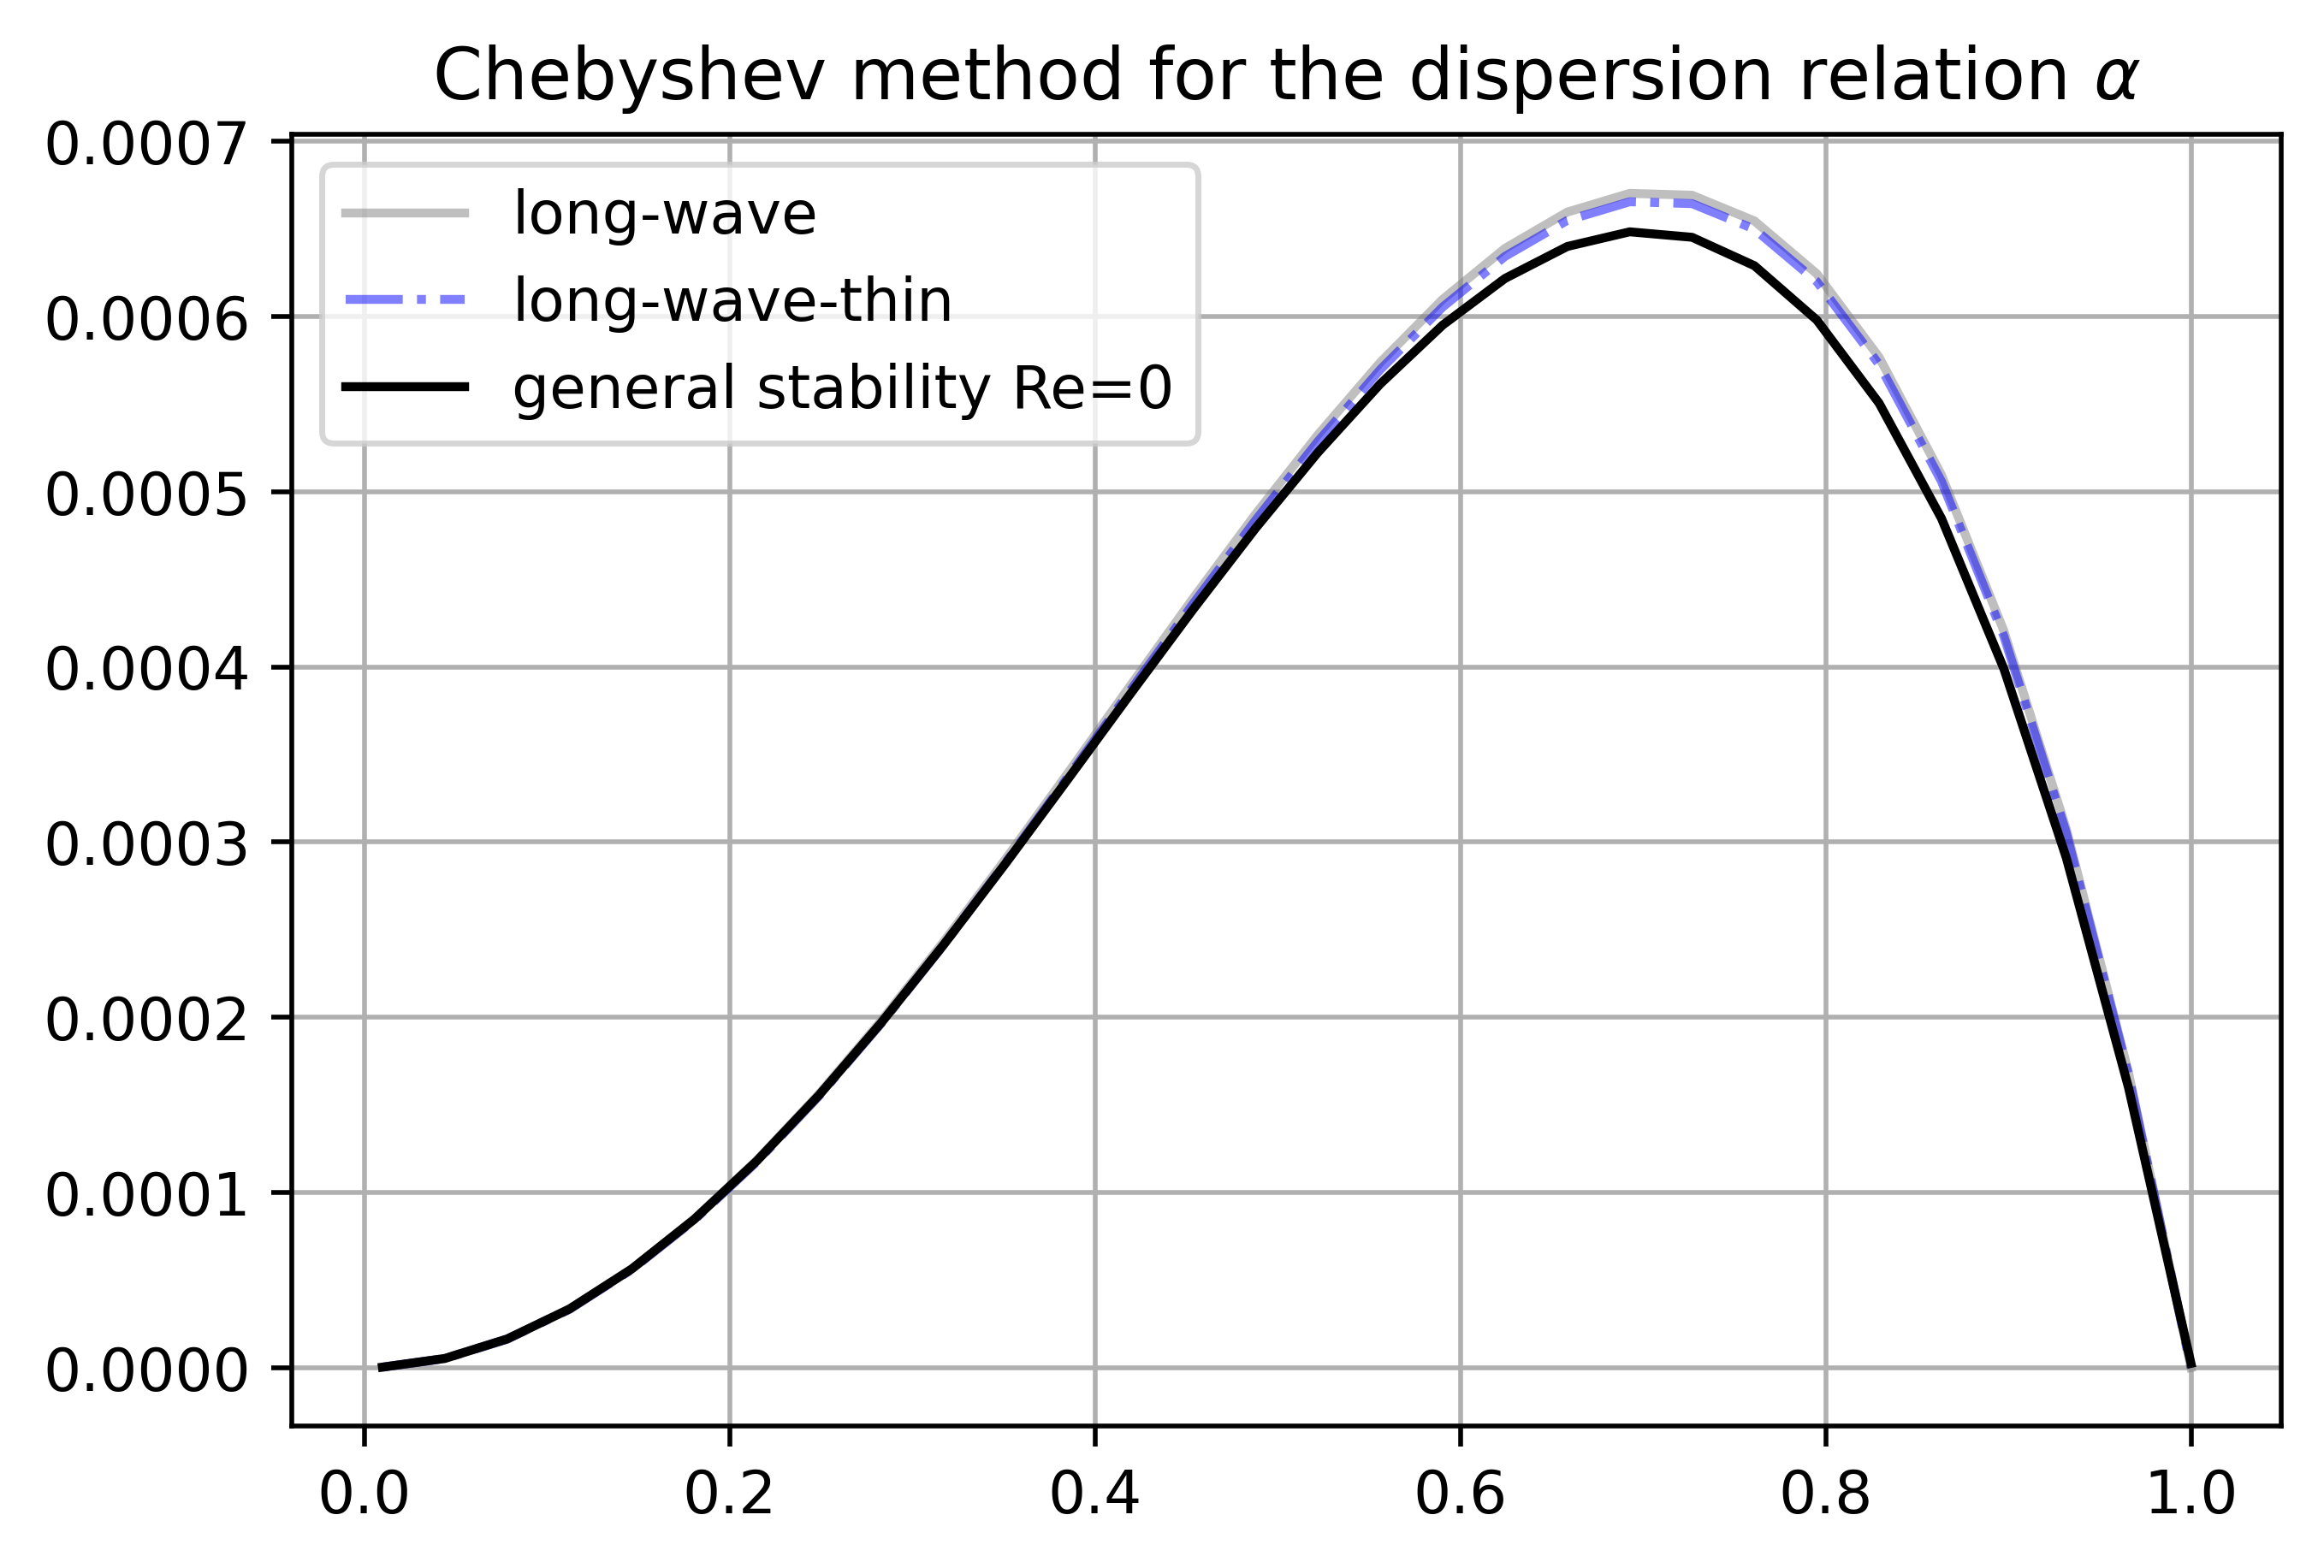

In [10]:
k_vect = kappa_vect/epsilon
D = 1-2*Ma
lambda_vect_thin = k_vect**2/3*(D - epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))
plt.figure(dpi=500)
plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='grey', alpha=0.5)
plt.plot(k_vect*epsilon, epsilon**2*lambda_vect_thin, '-.' , label='long-wave-thin', color='blue', alpha=0.5)
#plt.plot(kappa_vect, )
plt.plot(kappa_vect, epsilon*Lambda_vect.real, label ='general stability Re=0',color='black')
plt.legend()
plt.grid()
plt.title(r'Chebyshev method for the dispersion relation $\alpha$')
#plt.savefig(f'proof_of_working_method_chebyshev_alpha_{alpha}_with_Re_1.jpg')
plt.show()